In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
import urllib.parse
import bio_helper
import tools
import seaborn as sns
from tools import *
from importlib import reload
reload(bio_helper)
plt.style.use([])
import sys
sys.path.append("..")
from ms import finetune
from fdr_test import fixed_features

In [2]:
which = "chymo"
msms_file = f"/data/prosit/figs/fig235/{which}/maxquant/combined/txt/msms.txt"
raw_dir = f"/data/prosit/figs/fig235/{which}/raw"
fixed_features_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/prosit_l1"
tabels_file = fixed_features(
    msms_file, raw_dir, fixed_features_dir)

name, msms_data = tools.read_msms(msms_file)
msms_data = tools.filter_msms(name, msms_data)


msms_data = msms_data[:100000]
msms_data.sort(key=lambda x: int(x[name.index("id")]))
m_r = loc_msms_in_raw(msms_data, raw_dir)

matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_pre)]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]


100%|██████████| 100000/100000 [00:02<00:00, 35431.04it/s]


In [3]:
peptides = [i[0][name.index("Sequence")].replace("_", "") for i in m_r]
mo_peptides = [i[0][name.index("Modified sequence")].replace("_", "") for i in m_r]
charges = [int(i[0][name.index("Charge")]) for i in m_r]
precursor_mz = [float(i[0][name.index("m/z")]) for i in m_r]
andromeda = [float(i[0][name.index("Score")]) for i in m_r]
labels = [-1 if len(i[0][name.index("Reverse")]) else 1 for i in m_r]


In [58]:
from ms import model
import ms

frag_model = "pdeep2"
model_list = {
    "prosit_l1" : model.PrositFrag,
    "pdeep2" : model.pDeep2_nomod
}

checkpoints_list = {
    "prosit_l1": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_PrositFrag-1024.pth", 
    "pdeep2": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_pDeep2-1024.pth"
}
run_model = model_list[frag_model]()
run_model.load_state_dict(torch.load(checkpoints_list[frag_model], map_location="cpu"))
prosit = run_model.eval()

print(frag_model)
finetuned_prosit, _ = finetune.semisupervised_finetune(prosit, tabels_file, pearson=(frag_model == 'pdeep2'), enable_test=False)

torch.save(finetuned_prosit.state_dict(),
           f"/home/gus/Desktop/ms_pred/checkpoints/finetuned/{frag_model}_{which}.pth")


pdeep2
Run on cuda:0
Baseline Andromeda: 12641 66412 221246
---------------
Achieve best: Train: 50 4025 250520
Achieve best: Train: 90736 213033 285030
Achieve best: Train: 123178 228764 289720
Achieve best: Train: 124716 235316 292898
Train: 107275 231340 295471
Achieve best: Train: 150275 246641 297495
Train: 92327 234612 300512
Achieve best: Train: 155344 254360 303570
Achieve best: Train: 162628 257000 307066
Achieve best: Train: 153571 259002 310232


In [59]:
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)
prosit_sa, prosit_inten = get_sa_all(
    prosit, data_nce_cand, frag_msms, pearson=(frag_model == 'pdeep2'))
prosit_sa = prosit_sa.cpu().numpy()
prosit_inten = prosit_inten.cpu().numpy()

finetune_prosit_sa, finetune_prosit_inten = get_sa_all(
    finetuned_prosit, data_nce_cand, frag_msms, pearson=(frag_model == 'pdeep2'))
finetune_prosit_sa = finetune_prosit_sa.cpu().numpy()
finetune_prosit_inten = finetune_prosit_inten.cpu().numpy()


In [ ]:
combine_index = list(enumerate(zip(andromeda, prosit_sa, finetune_prosit_sa, labels)))
combine_index.sort(key=lambda x: x[1][0])

combine_index = [p for p in combine_index if p[1][-1] == 1]
for p in combine_index[-300:]:
    print(f"{p[0]:5d}\t{p[1][1]:.4f}\t{p[1][2]:.4f}\t{p[1][0]:.2f}")

DISNVKHVINF DISNVKHVINF


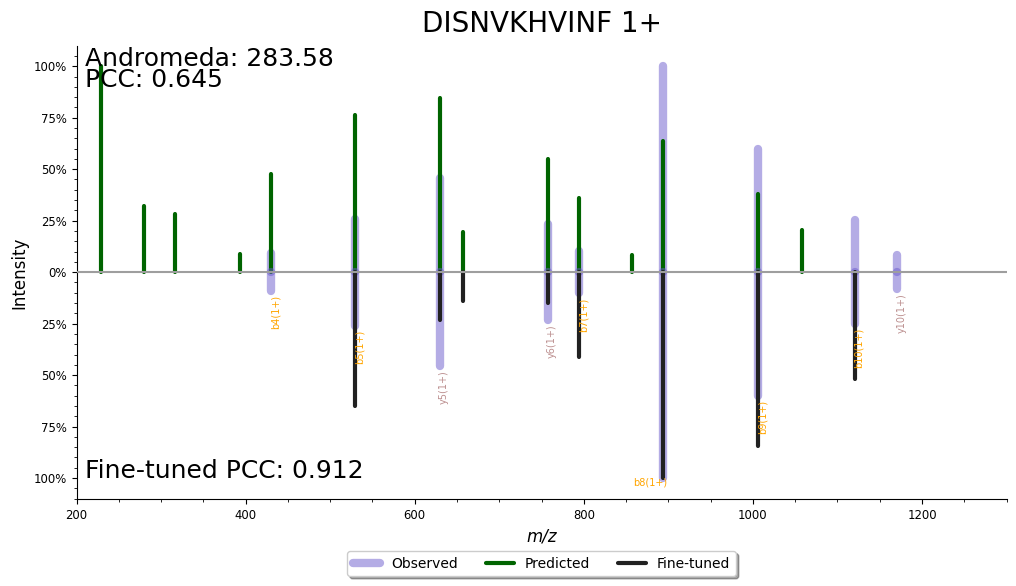

In [69]:
import spectrum_vis as sup
import matplotlib.ticker as mticker

plt.rcParams["font.family"] = "DejaVu Sans"

# which_psm = 7062
which_psm = 66317

# which_psm = 1085 # trypsin
# which_psm = 1192
ions = m_i[which_psm][0]
intensity = m_i[which_psm][1]
mass = m_i[which_psm][5]
peptide = peptides[which_psm]
print(peptide, mo_peptides[which_psm])
m_over_z = precursor_mz[which_psm]
charge = charges[which_psm]
pred_inten = prosit_inten[which_psm]
pred_inten[pred_inten<0] = 0
sa = prosit_sa[which_psm]
fine_pred_inten = finetune_prosit_inten[which_psm]
fine_pred_inten[fine_pred_inten < 0] = 0
fine_sa = finetune_prosit_sa[which_psm]


score_name = "SA" if (frag_model != "pdeep2") else "PCC"
pred_match = bio_helper.pair_backbone_with_mass(pred_inten, peptide, charge)
fine_pred_match = bio_helper.pair_backbone_with_mass(fine_pred_inten, peptide, charge)

raw_mass = [float(i) for i in matched_ions_pre[which_psm]['masses_raw'].split(' ')]
raw_intensities = [float(i) for i in matched_ions_pre[which_psm]['intensities_raw'].split(' ')]

# print(pred_match[0], pred_match[1])
spectrum_1 = sus.MsmsSpectrum("see", m_over_z, charge, mass, intensity, peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
spectrum_2 = sus.MsmsSpectrum("see", m_over_z, charge, pred_match[1], pred_match[0], peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)
spectrum_3 = sus.MsmsSpectrum("see", m_over_z, charge, fine_pred_match[1], fine_pred_match[0], peptide=peptide) .filter_intensity(min_intensity=0.05, max_num_peaks=50)

fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
fragment_tol_mass = 25
fragment_tol_mode = 'ppm'
spectrum_1 = spectrum_1.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
spectrum_2 = spectrum_2.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
spectrum_3 = spectrum_3.annotate_peptide_fragments(fragment_tol_mass, fragment_tol_mode, ion_types='by')
# sup.mirror(spectrum_1, spectrum_2)
gd_color = {None: "slateblue"}
before_color = {None: "#212121", "special": "slateblue"}
after_color = {None: "darkgreen"}

sup.spectrum(spectrum_1, grid=False, annotate_ions=False, color_ions=False, linewidth=6, alpha=0.5, ax=ax, colors=gd_color, label="Observed")
sup.spectrum(spectrum_2, grid=False, ax=ax, annotate_ions=False, color_ions=False, colors=after_color, label="Predicted")

x_min = 200
x_max = 1300

sup.spectrum_ions_offered(ions, intensity, mass, grid=False, annotate_ions=True, mirror_intensity=True,
             color_ions=True, linewidth=6, alpha=0.5, ax=ax, colors=gd_color, max_mz=x_max)
sup.spectrum(spectrum_3, grid=False, mirror_intensity=True, color_ions=False,
             ax=ax, annotate_ions=False, colors=before_color, label="Fine-tuned")

ax.set_ylim(-1.1, 1.1)
ax.set_xlim(x_min, x_max)

ax.axhline(0, color="#9E9E9E", zorder=10)
ax.yaxis.set_major_locator(mticker.AutoLocator())
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
ax.text(x_min+10, 1, f"Andromeda: {andromeda[which_psm]}", fontsize=18)
ax.text(x_min+10, .9, f"{score_name}: {sa:.3f}", fontsize=18)
ax.text(x_min+10, -1., f"Fine-tuned {score_name}: {fine_sa:.3f}", fontsize=18)

# fig.suptitle(, fontsize=20)
ax.set_title(f"{peptide} {charge}+", pad=10, fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(
    f"fig/fig1-lowsa-high-andromeda-{which}-{frag_model}-{which_psm}.pdf", dpi=300, bbox_inches="tight")
